In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 192321657.36it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35399092.29it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67768308.28it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7254580.64it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# Auto Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self,l_space_dim):
    super().__init__()
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(1,4,(4,4), stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(4,8,(4,4), stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.Conv2d(8,16,(3,3), stride=2, padding=1),
        nn.ReLU(True),
    )

    self.Dense = nn.Sequential(
        nn.Flatten(),
        nn.Linear(4 * 4 * 16, 128),
        nn.ReLU(True),
        nn.Linear(128, l_space_dim)
    )

  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.Dense(x)
    return x

class Decoder(nn.Module):
  def __init__(self,l_space_dim):
    super().__init__()
    self.Dense = nn.Sequential(
            nn.Linear(l_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 4 * 4 * 16),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(16, 4, 4))
        )

    self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, (3,3), 
            stride=2,padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, (4,4), stride=2, 
            padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, (4,4), stride=2, 
            padding=1)
    )

  def forward(self, x):
    x = self.Dense(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self,l_space_dim):
    super().__init__()
    self.encoder = Encoder(l_space_dim)
    self.decoder = Decoder(l_space_dim)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
from pickle import APPEND
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 8

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
ae = AutoEncoder(d)
params_to_optimize = [
    {'params': ae.parameters()},
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
ae.to(device)

Selected device: cuda


AutoEncoder(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
    (Dense): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (Dense): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ReLU(inplace=True)
      (4): Unflatten(dim=1, unflattened_size=(16, 4, 4

In [ ]:
from torchsummary import summary

summary(ae, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 14, 14]              68
              ReLU-2            [-1, 4, 14, 14]               0
            Conv2d-3              [-1, 8, 7, 7]             520
       BatchNorm2d-4              [-1, 8, 7, 7]              16
              ReLU-5              [-1, 8, 7, 7]               0
            Conv2d-6             [-1, 16, 4, 4]           1,168
              ReLU-7             [-1, 16, 4, 4]               0
           Flatten-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                    [-1, 8]           1,032
          Encoder-12                    [-1, 8]               0
           Linear-13                  [-1, 128]           1,152
             ReLU-14                  [

In [ ]:
def train_epoch(ae, device, dataloader, loss_fn, optimizer,ToPrint = False):
    # Set train mode for both the encoder and the decoder
    ae.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        #pass the data through the auto encoder
        preds = ae(image_batch)
        # Evaluate loss
        loss = loss_fn(preds, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if ToPrint:
          print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
print(train_epoch(ae,device,train_loader,loss_fn,optim))

0.12799782


In [ ]:
def test_epoch(ae, device, dataloader, loss_fn,ToPrint = False):
    # Set eval mode for both the encoder and the decoder
    ae.eval()
    test_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        #pass the data through the auto encoder
        preds = ae(image_batch)
        # Evaluate loss
        loss = loss_fn(preds, image_batch)
        # Print batch loss
        if ToPrint:
          print('\t partial train loss (single batch): %f' % (loss.data))
        test_loss.append(loss.detach().cpu().numpy())

    return np.mean(test_loss)

In [ ]:
print(test_epoch(ae,device,test_loader,loss_fn))

0.07083972


In [ ]:
def training_loop(ae, device, dataloader_tr,dataloader_te, loss_fn, optimizer,epochs = 10,ToPrint_each_step = False):
    train_losses = []
    test_losses = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i in range(epochs): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        train_losses += [train_epoch(ae,device,dataloader_tr,loss_fn,optim,ToPrint = ToPrint_each_step)]
        test_losses += [test_epoch(ae, device, dataloader_te, loss_fn,ToPrint = ToPrint_each_step)]
        # Print losses
        print(f"epoch: {i+1}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    return {"train_loss":train_losses,"test_loss":test_losses}

In [ ]:
loss_d = training_loop(ae, device, dataloader_tr = train_loader,dataloader_te = test_loader, loss_fn = loss_fn,optimizer = optim,epochs = 20,ToPrint_each_step = False)

epoch: 1, train loss: 0.05768263712525368, test loss: 0.05054875463247299
epoch: 2, train loss: 0.04754899442195892, test loss: 0.04556185007095337
epoch: 3, train loss: 0.04366092383861542, test loss: 0.042431674897670746
epoch: 4, train loss: 0.04088474437594414, test loss: 0.03995760530233383
epoch: 5, train loss: 0.038513198494911194, test loss: 0.037666141986846924
epoch: 6, train loss: 0.036246590316295624, test loss: 0.035387806594371796
epoch: 7, train loss: 0.03402063250541687, test loss: 0.033258356153964996
epoch: 8, train loss: 0.03187226131558418, test loss: 0.031015604734420776
epoch: 9, train loss: 0.02989298664033413, test loss: 0.02903340384364128
epoch: 10, train loss: 0.028186418116092682, test loss: 0.027508873492479324
epoch: 11, train loss: 0.026708055287599564, test loss: 0.02616863325238228
epoch: 12, train loss: 0.025386163964867592, test loss: 0.02486211061477661
epoch: 13, train loss: 0.02424309402704239, test loss: 0.023824593052268028
epoch: 14, train loss:

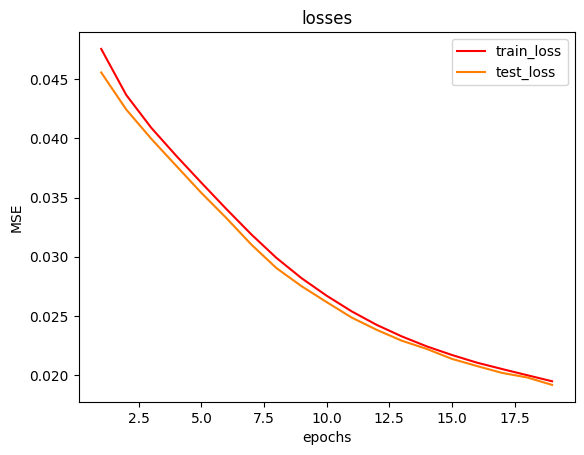

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

length = len(list(loss_d.values())[0])
X = np.arange(0, length)
cmap = cm.autumn
norm = Normalize(vmin=0, vmax=len(loss_d))
for idx,k in enumerate(loss_d.keys()):
  plt.plot(X[1:],loss_d[k][1:],label = k,color = cmap(norm(idx)))
plt.legend()
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("losses")
plt.show()

In [ ]:
from matplotlib import pyplot as plt

def before_and_after(before,after):
  fig, axs = plt.subplots(len(before), 2)
  for ax,ims in zip(axs,zip(before,after)):
    x,y = ims
    ax[0].imshow(x)
    ax[1].imshow(y)
  plt.show()

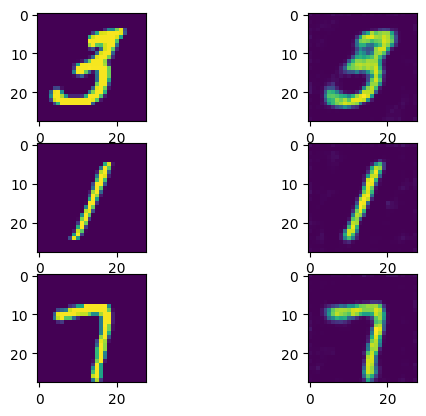

None


In [ ]:
x,_ = next(iter(valid_loader))
y = torch.squeeze(ae(x[:3].to(device))).cpu()
y = y.detach().numpy()
print(before_and_after(torch.squeeze(x[:3]),y))

# Variational auto encoder

In [ ]:
class V_Encoder(nn.Module):
  def __init__(self,l_space_dim):
    super().__init__()
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(1,4,(4,4), stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(4,8,(4,4), stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.Conv2d(8,16,(3,3), stride=2, padding=1),
        nn.ReLU(True),
    )

    self.Dense_mu = nn.Sequential(
        nn.Flatten(),
        nn.Linear(4 * 4 * 16, 128),
        nn.ReLU(True),
        nn.Linear(128, l_space_dim)
    )

    self.Dense_std = nn.Sequential(
        nn.Flatten(),
        nn.Linear(4 * 4 * 16, 128),
        nn.ReLU(True),
        nn.Linear(128, l_space_dim)
    )

  def forward(self, x):
    x = self.encoder_cnn(x)
    mu = self.Dense_mu(x)
    log_std = self.Dense_std(x)
    return mu,log_std,torch.exp(log_std)

class V_Decoder(nn.Module):
  def __init__(self,l_space_dim,device):
    super().__init__()
    self.Dense = nn.Sequential(
            nn.Linear(l_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 4 * 4 * 16),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(16, 4, 4))
        )

    self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, (3,3), 
            stride=2,padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, (4,4), stride=2, 
            padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, (4,4), stride=2, 
            padding=1)
    )

    self.device = device

  def forward(self, mu,log_std = None):
    if log_std == None:
      log_std = torch.full_like(mu,-10)
    noise = torch.randn_like(log_std).to(self.device)
    x = noise*torch.exp(log_std) + mu
    x = self.Dense(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
class VarAutoEncoder(nn.Module):
  def __init__(self,l_space_dim,device):
    super().__init__()
    self.device = device
    self.dim = l_space_dim
    self.v_encoder = V_Encoder(l_space_dim)
    self.v_decoder = V_Decoder(l_space_dim,device)

  def forward(self, x):
    mu,log_std,_ = self.v_encoder(x)
    out = self.v_decoder(mu,log_std)
    return {"input":x,"mean":mu,"log standart deviation":log_std,"output":out}

  def calc_loss(loss_dict):
    mse = torch.nn.MSELoss()
    rec_loss = mse(loss_dict["input"],loss_dict["output"])
    kl_loss = -0.5 * torch.mean(1 + loss_dict["log standart deviation"] - loss_dict["mean"]**2 - torch.exp(loss_dict["log standart deviation"]))
    return {"loss":rec_loss+0.04*kl_loss,"rec_loss":rec_loss,"kl_loss":0.04*kl_loss}

  def encode(self, x):
    return self.v_encoder(x)
  
  def decode(self, mu, std):
    return self.v_decoder(x)

  def gen_random(self,images_number):
    noise = torch.randn((images_number,self.dim)).to(self.device)
    return self.v_decoder(noise)

  def interpolation(self,image1,image2,num_of_inters):
    vec1_mu,_,_ = self.v_encoder(torch.unsqueeze(image1.to(self.device),dim = 0))
    vec2_mu,_,_ = self.v_encoder(torch.unsqueeze(image2.to(self.device),dim = 0))
    inters = [torch.squeeze(image1.to(self.device))]
    for i in range(1,(num_of_inters+1)):
      dec_vec = ((num_of_inters+1 - i)/(num_of_inters+1))*vec1_mu+(i/(num_of_inters+1))*vec2_mu
      dec_image = torch.squeeze(self.v_decoder(dec_vec))
      inters += [dec_image]
    inters += [torch.squeeze(image2.to(self.device))]
    return torch.stack(inters)

In [ ]:
from pickle import APPEND
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 10

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
v_ae = VarAutoEncoder(d,device).to(device)
params_to_optimize = [
    {'params': v_ae.parameters()},
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
v_ae.to(device)

Selected device: cuda


VarAutoEncoder(
  (v_encoder): V_Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): ReLU(inplace=True)
    )
    (Dense_mu): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (Dense_std): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (v_decoder): V_Decoder(
    (Dense): S

In [ ]:
x,_ = next(iter(valid_loader))
y = VarAutoEncoder.calc_loss(v_ae(x.to(device)))
print(y)
#y = y.detach().numpy()

{'loss': tensor(0.2839, device='cuda:0', grad_fn=<AddBackward0>), 'rec_loss': tensor(0.2837, device='cuda:0', grad_fn=<MseLossBackward0>), 'kl_loss': tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)}


In [ ]:
from torchsummary import summary

summary(v_ae, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 14, 14]              68
              ReLU-2            [-1, 4, 14, 14]               0
            Conv2d-3              [-1, 8, 7, 7]             520
       BatchNorm2d-4              [-1, 8, 7, 7]              16
              ReLU-5              [-1, 8, 7, 7]               0
            Conv2d-6             [-1, 16, 4, 4]           1,168
              ReLU-7             [-1, 16, 4, 4]               0
           Flatten-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 16]           2,064
          Flatten-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [ ]:
def v_train_epoch(v_ae, device, dataloader, loss_fn, optimizer,ToPrint = False):
    # Set train mode for both the encoder and the decoder
    v_ae.train()
    train_loss = []
    train_kl_loss = []
    train_recon_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        #pass the data through the auto encoder
        preds_dict = v_ae(image_batch)
        # Evaluate loss
        #loss = loss_fn(preds["output"], image_batch)
        loss = VarAutoEncoder.calc_loss(preds_dict)
        total_loss = loss["loss"]
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Print batch loss
        if ToPrint:
          print('\t partial train loss (single batch): %f' % (total_loss.data))
        train_loss.append(total_loss.detach().cpu().numpy())
        train_kl_loss.append(loss["kl_loss"].detach().cpu().numpy())
        train_recon_loss.append(loss["rec_loss"].detach().cpu().numpy())

    return {"total loss":np.mean(train_loss),"kl_loss":np.mean(train_kl_loss),"recon loss":np.mean(train_recon_loss)}

In [ ]:
print(v_train_epoch(v_ae,device,train_loader,loss_fn,optim))

{'total loss': 0.16025245, 'kl_loss': 0.00010061677, 'recon loss': 0.16015184}


In [ ]:
for i in range(15):
  print(v_train_epoch(v_ae,device,train_loader,loss_fn,optim))

{'total loss': 0.1712445, 'kl_loss': 3.2277992e-05, 'recon loss': 0.17121221}
{'total loss': 0.077104524, 'kl_loss': 1.7193908e-05, 'recon loss': 0.07708733}
{'total loss': 0.068123415, 'kl_loss': 0.0009676319, 'recon loss': 0.06715578}
{'total loss': 0.06567674, 'kl_loss': 0.0016835546, 'recon loss': 0.06399318}
{'total loss': 0.06374361, 'kl_loss': 0.0029870376, 'recon loss': 0.060756583}
{'total loss': 0.06254599, 'kl_loss': 0.003425963, 'recon loss': 0.059120025}
{'total loss': 0.06179918, 'kl_loss': 0.0037068164, 'recon loss': 0.058092367}
{'total loss': 0.061240852, 'kl_loss': 0.0038767694, 'recon loss': 0.05736408}
{'total loss': 0.06079884, 'kl_loss': 0.0040155854, 'recon loss': 0.05678326}
{'total loss': 0.06041403, 'kl_loss': 0.0041817715, 'recon loss': 0.05623226}
{'total loss': 0.060026616, 'kl_loss': 0.0043575154, 'recon loss': 0.055669107}
{'total loss': 0.0596106, 'kl_loss': 0.0045445715, 'recon loss': 0.055066023}
{'total loss': 0.059208628, 'kl_loss': 0.004699135, 'rec

In [ ]:
x,_ = next(iter(valid_loader))
y = torch.squeeze(v_ae(x[:3].to(device))['output']).cpu()
y = y.detach().numpy()
print(before_and_after(torch.squeeze(x[:3]),y))
print(v_ae.v_encoder(x[:3].to(device)))

<IPython.core.display.Javascript object>

None
(tensor([[-2.8951e-03, -1.4889e-03, -5.3315e-01,  5.5068e-03, -4.8748e-03,
          1.5997e-01,  1.0377e-02,  1.4877e-03, -1.3133e-02, -5.3298e-03,
         -1.1199e-03, -1.3960e-03, -2.3452e-03,  2.4480e-03, -7.6012e-03,
          1.1496e-02],
        [-4.6134e-03, -3.7514e-03,  1.4098e-01,  1.4969e-02,  2.2311e-02,
          1.3658e+00,  1.2910e-02,  6.4397e-03, -2.8236e-02, -2.2694e-02,
         -3.8885e-03, -5.5214e-03,  2.2091e-02,  5.6733e-03, -1.6704e-02,
         -9.8074e-03],
        [-1.2672e-02,  1.6267e-04,  1.2724e+00,  8.1766e-03,  7.6896e-03,
         -4.6523e-01, -6.8356e-03, -1.1061e-02,  1.8237e-03,  9.5643e-03,
          3.2052e-03, -1.1605e-02, -4.4289e-03,  1.5486e-02,  1.7626e-02,
         -1.6792e-03]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.5155, -0.5142, -2.8060, -0.5827, -0.5870, -3.1802, -0.5907, -0.5415,
         -0.6223, -0.5337, -0.5241, -0.5488, -0.5081, -0.5584, -0.5509, -0.5635],
        [-0.0698, -0.0647, -2.5000, -0.0988, -0.073

In [ ]:
ys = v_ae.gen_random(5)
for y in ys:
  detached = y.cpu().detach().numpy()
  plt.imshow(np.squeeze(detached))
  plt.show()

In [ ]:
x,_ = next(iter(valid_loader))
inters = v_ae.interpolation(image1 = x[2],image2 = x[3],num_of_inters = 62)
for y in inters:
  detached = y.cpu().detach().numpy()
  plt.imshow(np.squeeze(detached),cmap = 'Greys')
  plt.show()

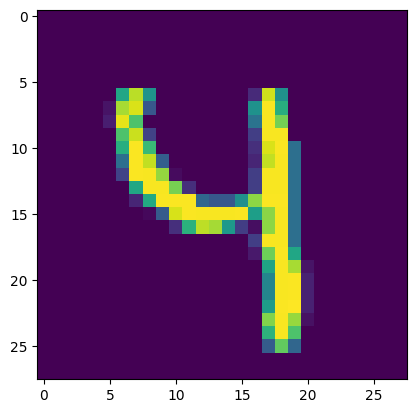

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
inters = v_ae.interpolation(image1 = x[72],image2 = x[19],num_of_inters = 1000)
fig, ax = plt.subplots()

ani_inters = torch.unsqueeze(inters,dim = 1).permute(0,2,3,1).cpu().detach() # Permuting to (Bx)HxWxC format
frames = [[ax.imshow(ani_inters[i])] for i in range(len(ani_inters))]

ani = animation.ArtistAnimation(fig, frames,interval=0.1)
ani.save("yourgif.gif")
plt.show()